## ***1. Importing Libary***

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score

## ***2. Preparing the Data Sets***

In [61]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
features = breast_cancer_wisconsin_diagnostic.data.features
labels = breast_cancer_wisconsin_diagnostic.data.targets

# Flatten the labels array to encode below
labels = np.array(labels).ravel()

label_encoder = LabelEncoder() #Encode to 0, 1, easy to visualize
labels = label_encoder.fit_transform(labels)

# Split the data into training and test sets

splitSize = [40, 60, 80, 90]

listData = []

for size in splitSize:
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=size/100, random_state=1, shuffle=True, stratify=labels)
    listData.append([X_train, X_test, y_train, y_test])

## ***Visualizing all data sets***

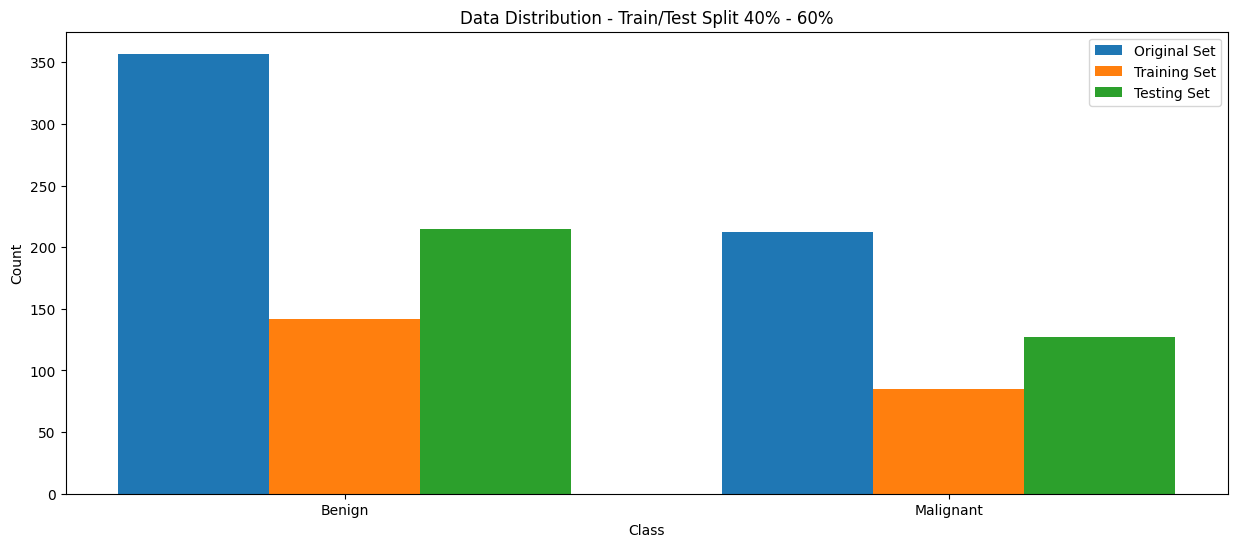

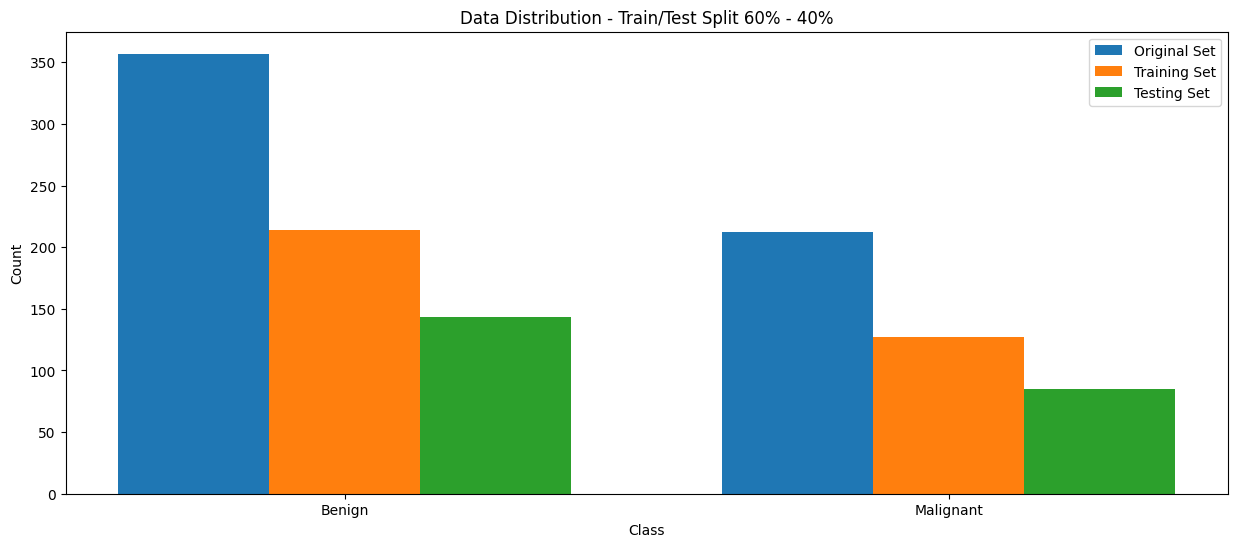

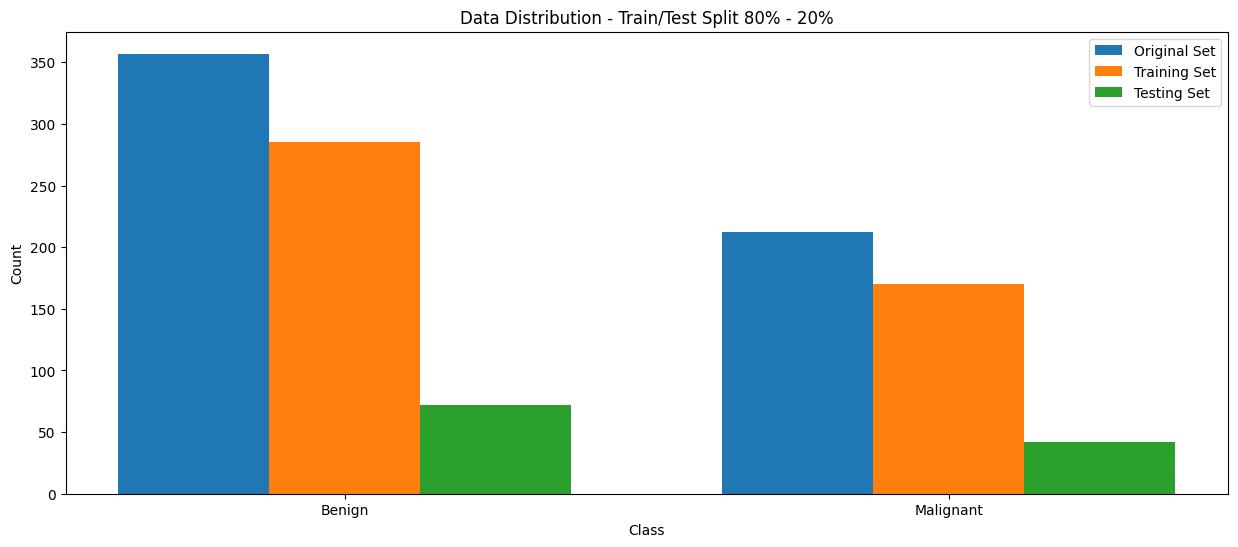

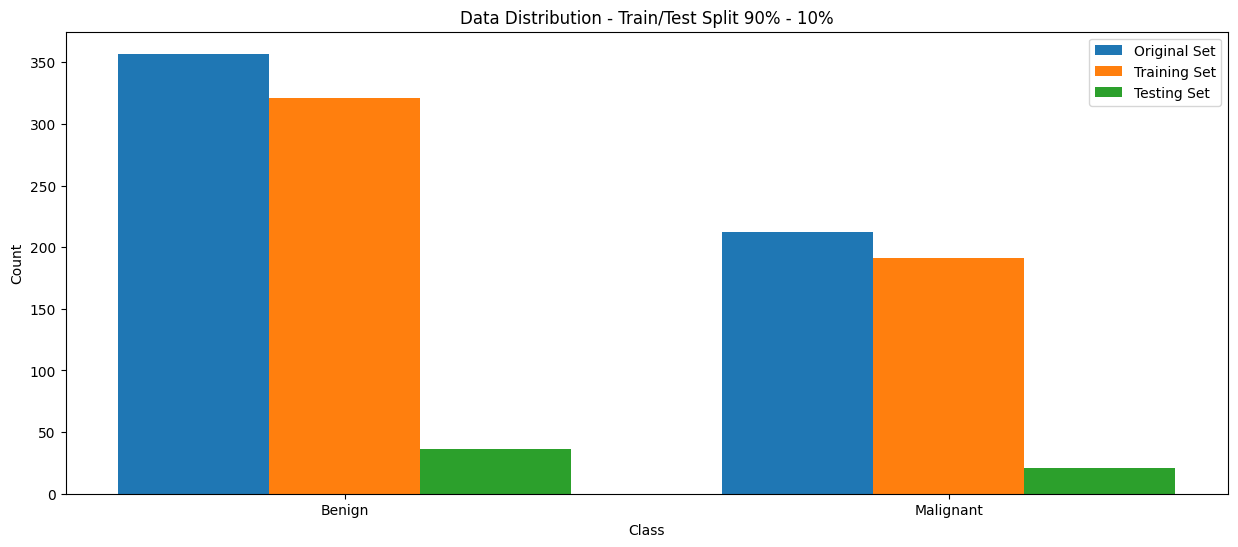

In [62]:
listLabels = list(np.unique(labels)) # 0 -> Benign, 1 -> Malignant
originalSet_labelCounts = list(np.bincount(labels))

for i, size in enumerate(splitSize):
    _, _, y_train, y_test = listData[i]
    trainingSet_labelCounts = list(np.bincount(y_train, minlength=len(listLabels))) #Maybe missing labels, minlength to mark 0 to those
    testingSet_labelCounts = list(np.bincount(y_test, minlength=len(listLabels)))

    plt.figure(figsize=(15, 6))

    # Create x-coordinates for each data
    x = np.arange(0, len(listLabels))

    # Set the width of each bar
    width = 0.25

    # Create bar chart
    plt.bar(x - width, originalSet_labelCounts, width, label="Original Set")
    plt.bar(x, trainingSet_labelCounts, width, label="Training Set")
    plt.bar(x + width, testingSet_labelCounts, width, label="Testing Set")

    # Add labels, title, and legend
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(f"Data Distribution - Train/Test Split {(size):.0f}% - {(100-size):.0f}%")
    plt.xticks(x, ["Benign", "Malignant"])
    plt.legend()

    # Save and display the plot
    plt.savefig(f"Output/DataDistribution/split_{int((size))}.png")
    plt.show()

## ***3. Building the decision tree classifiers***

In [66]:
listTree = []
for i, (X_train, X_test, y_train, y_test) in enumerate(listData):
    #Build tree by using DecisionTreeClassifier in sklearn
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    
    #Fit function to build tree
    clf.fit(X_train, y_train)
    listTree.append(clf)
    #Format tree
    plt.figure(figsize=(50,30))
    plot_tree(clf, 
              feature_names=features.columns,  
              class_names=[ "Benign","Malignant"],
              filled=True, 
              rounded=True,  
              fontsize=25 if i < 2 else 20)
    
    # Add title and save the plot
    plt.title(f"Decision Tree Visualization - Train/Test Split {(splitSize[i])}% - {(100-splitSize[i])}%", fontsize=50)
    plt.savefig(f"Output/DecisionTreeClassifier/split_{int((splitSize[i]))}.png")
    # plt.show() #Picture is too big, so I won't show it, you can check it in the Output folder or Report File
    plt.close()

## ***4. Evaluating the decision tree classifiers***

In [67]:
for i, ((_, X_test, _, y_test), clf) in enumerate(zip(listData, listTree)): #ignore training data because we have already trained the model

    # Predict the test set results
    y_pred = clf.predict(X_test)
    
    # Create classification report
    report = classification_report(y_test, y_pred, target_names=["Benign", "Malignant"], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Format the DataFrame to show only two decimal places
    report_df = report_df.round(2)
    
    # Handle missing classes by adding them with default values
    for class_name in ["Benign", "Malignant"]:
        if class_name not in report_df.index:
            report_df.loc[class_name] = [0] * len(report_df.columns)
            report_df.loc[class_name, 'support'] = 0  # Add support column

    # Remove accuracy from precision and recall columns
    report_df.loc['accuracy', ['precision', 'recall']] = None

    # Plot and save classification report as a table
    plt.figure(figsize=(10, 6))
    plt.axis('off')  # Turn off the axis

    cell_text = report_df.values.tolist()
    cell_text_formatted = []
    for row in cell_text:
        cell_text_formatted.append([f"{value:.2f}" if not pd.isnull(value) else "" for value in row])
                
    # Create a table and add it to the plot
    table = plt.table(cellText=cell_text_formatted,
                      rowLabels=report_df.index,
                      colLabels=report_df.columns,
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0, 1, 1])
    
    # Set table font size and other settings
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([i for i in range(len(report_df.columns))])
    
    # Add title
    plt.title(f'Classification Report - Train/Test Split {(splitSize[i])}% - {(100-splitSize[i])}%')
    
    # Save the plot as a PNG file
    plt.savefig(f"Output/ClassificationReport/split_{int((splitSize[i]))}.png", bbox_inches='tight')
    plt.close()

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot and save confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=[ "Benign","Malignant"], yticklabels=[ "Benign","Malignant"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Train/Test Split {(splitSize[i])}% - {(100-splitSize[i])}%')
    plt.savefig(f"Output/ConfusionMatrix/split_{int((splitSize[i]))}.png")
    plt.close()

## ***5. The depth and accuracy of a decision tree***

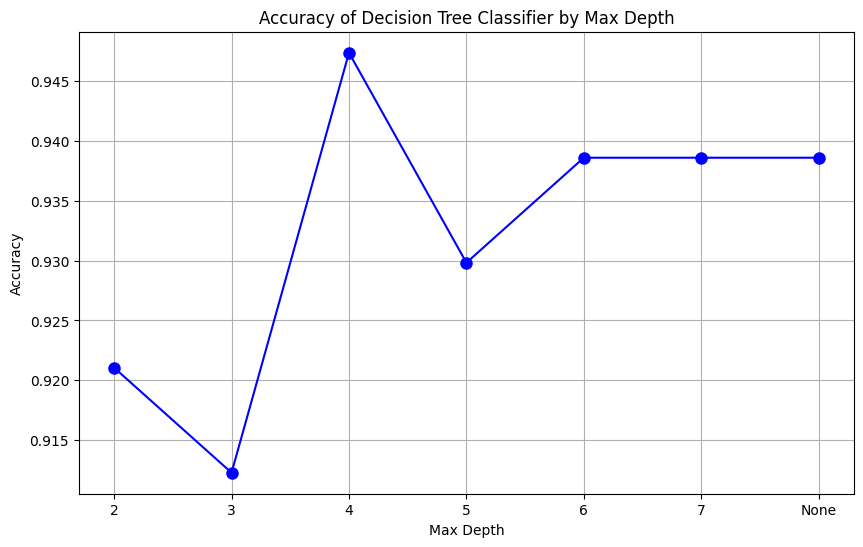

In [68]:
max_depth_values = [2, 3, 4, 5, 6, 7, None]
results = []
X_train, X_test, y_train, y_test = listData[splitSize.index(80)]

for depth in max_depth_values:
    #Build tree by using DecisionTreeClassifier in sklearn
    clf = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    
    #Fit function to build tree
    clf.fit(X_train, y_train)
    
    # Predict the test set results
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results.append(accuracy)
    
    #Format tree
    plt.figure(figsize=(50,30))
    plot_tree(clf, 
              feature_names=features.columns,  
              class_names=[ "Benign","Malignant"],
              filled=True, 
              rounded=True,  
              fontsize= 25 if depth == 2 or depth == 3 else 20)
    
    # Add title and save the plot
    plt.title(f'Decision Tree Visualization - max_depth {depth}', fontsize=50)
    plt.savefig(f"Output/Accuracy/decision_tree_depth_{depth}.png")
    plt.close()  # Close the plot to free memory

# Replace None with a descriptive string for the table
depth_labels = ['None' if depth is None else depth for depth in max_depth_values]

# Format the accuracy values to 2 decimal places
formatted_accuracies = [f"{acc:.2f}" for acc in results]

# Create a DataFrame for results
results_df = pd.DataFrame({
    'max_depth': depth_labels,
    'Accuracy': formatted_accuracies
})

# Plot the table
fig, ax = plt.subplots(figsize=(10, 4))  # Set the size of the plot
ax.axis('tight')
ax.axis('off')
table_data = results_df.values
table_columns = results_df.columns
table = plt.table(cellText=table_data, colLabels=table_columns, cellLoc='center', loc='center', 
                  bbox=[0, 0, 1, 1], colColours=['#f5f5f5']*len(table_columns))

# Add title and save the table plot
plt.title('Decision Tree Accuracy by max_depth')
plt.savefig("Output/Accuracy/accuracy_table.png")
plt.close()

# Plot accuracy as a function of max_depth
plt.figure(figsize=(10, 6))
plt.plot(depth_labels, results, marker='o', linestyle='-', color='b', markersize=8)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy of Decision Tree Classifier by Max Depth')
plt.grid(True)
plt.savefig("Output/Accuracy/accuracy_vs_depth.png")
plt.show()